# Production Technology

The dataset contains `N = 441` firms observed over `T = 12` years, 1968-1979. There variables are: 
* `lcap`: Log of capital stock, $k_{it}$ 
* `lemp`: log of employment, $\ell_{it}$ 
* `ldsa`: log of deflated sales, $y_{it}$
* `year`: the calendar year of the observation, `year` $ = 1968, ..., 1979$, 
* `firmid`: anonymized indicator variable for the firm, $i = 1, ..., N$, with $N=441$. 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import w3_LinearModels as lm
from scipy.stats import chi2
import numpy.linalg as la
from numpy import linalg as la
import scipy.stats as st
import importlib.util, sys


In [2]:
# --- loader ---
def load_firm_data(path="firms.csv"):
    dat = pd.read_csv(path)
    y = dat["ldsa"].values.reshape(-1, 1)
    x = np.column_stack([np.ones(dat.shape[0]), dat["lcap"].values, dat["lemp"].values])
    T = dat["year"].nunique()  # 12
    label_y = "Log deflated sales"
    label_x = ["Constant", "Capital", "Labor"]
    return y, x, T, dat["year"].values, label_y, label_x

# --- import your course module from file ---
module_path = "w3_LinearModels.py"
spec = importlib.util.spec_from_file_location("w3_LinearModels", module_path)
lm = importlib.util.module_from_spec(spec)
sys.modules["w3_LinearModels"] = lm
spec.loader.exec_module(lm)

# --- run POLS ---
y, x, T, year, label_y, label_x = load_firm_data("firms.csv")
pols_result = lm.estimate(y, x, T=T)  # add robust_se=True if you want robust SEs
lm.print_table((label_y, label_x), pols_result, title="Pooled OLS", floatfmt=".4f")


Pooled OLS
Dependent variable: Log deflated sales

            Beta      Se    t-values
--------  ------  ------  ----------
Constant  0.0000  0.0161      0.0000
Capital   0.3100  0.0324      9.5810
Labor     0.6748  0.0366     18.4526
R² = 0.914
σ² = 0.131


In [3]:
dat = pd.read_csv('firms.csv')

In [4]:
dat.sample(5)

,firmid,year,lcap,lemp,ldsa
4003,334,1975,-1.845570,-1.505960,-1.750110
4419,369,1971,-2.098710,-1.537660,-1.574830
2929,245,1969,-0.856710,-0.704818,-0.699617
2534,212,1970,0.656656,0.865232,1.038985
3001,251,1969,2.949467,2.739544,2.407122


In [5]:
dat.year.unique()

array([1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979])

# Descriptives

In [6]:
dat.describe()

,firmid,year,lcap,lemp,ldsa
count,5292.000000,5292.000000,5.292000e+03,5.292000e+03,5.292000e+03
mean,221.000000,1973.500000,-7.125472e-09,-1.252834e-08,4.695767e-09
std,127.317437,3.452379,1.310973e+00,1.180122e+00,1.232499e+00
min,1.000000,1968.000000,-3.864950e+00,-3.382780e+00,-3.551540e+00
25%,111.000000,1970.750000,-9.083267e-01,-7.855270e-01,-9.279720e-01
50%,221.000000,1973.500000,-1.180615e-01,-1.137295e-01,-1.029710e-01
75%,331.000000,1976.250000,9.063340e-01,7.930060e-01,8.562296e-01
max,441.000000,1979.000000,4.103687e+00,3.371332e+00,3.913391e+00


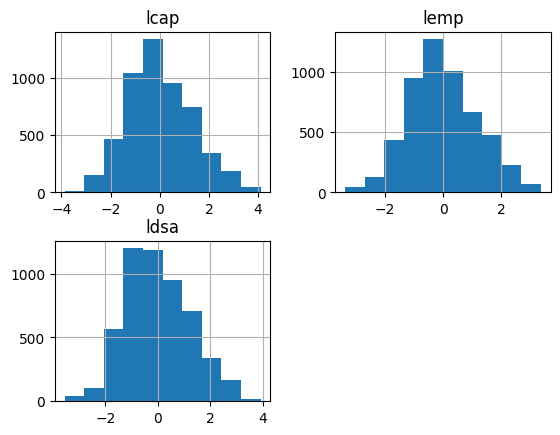

In [7]:
dat[['lcap','lemp','ldsa']].hist();

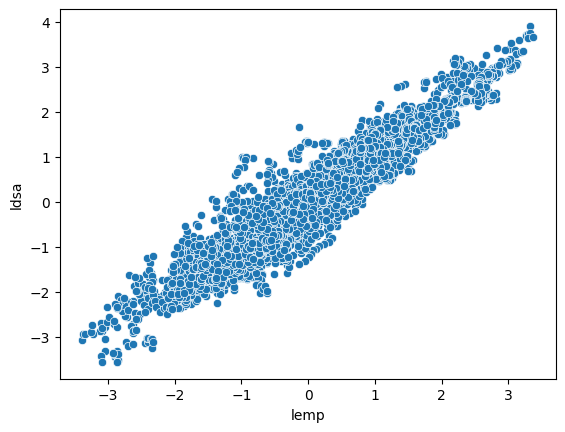

In [8]:
sns.scatterplot(x='lemp', y='ldsa', data=dat); 

# Converting data to numpy format 

In [9]:
dat.ldsa.values.shape

(5292,)

In [10]:
N = dat.firmid.unique().size
T = dat.year.unique().size
assert dat.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

Data has N=441 and T=12


Extract data from `pandas` to `numpy` arrays. 

In [11]:
y = dat.ldsa.values.reshape((N*T,1))

ones = np.ones((N*T,1))
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
X = np.hstack([ones, l, k])

In [12]:
from numpy.linalg import inv

# OLS estimation: beta_hat = (X'X)^(-1) X'y
beta_hat = inv(X.T @ X) @ (X.T @ y)
print("OLS coefficients:\n", beta_hat)

OLS coefficients:
 [[1.53587616e-08]
 [6.74774492e-01]
 [3.10040758e-01]]


In [13]:
import w3_LinearModels as lm

# Load firm data
y, x, T, year, label_y, label_x = load_firm_data()

# Pooled OLS estimation
pols_result = lm.estimate(y, x, T=T)

# Print results in a nice table
lm.print_table((label_y, label_x), pols_result, title="Pooled OLS", floatfmt='.4f')


Pooled OLS
Dependent variable: Log deflated sales

            Beta      Se    t-values
--------  ------  ------  ----------
Constant  0.0000  0.0161      0.0000
Capital   0.3100  0.0324      9.5810
Labor     0.6748  0.0366     18.4526
R² = 0.914
σ² = 0.131


In [14]:
pols_result_robust = lm.estimate(y, x, T=T, robust_se=True)
lm.print_table((label_y, label_x), pols_result_robust, title="Pooled OLS (Robust SE)", floatfmt='.4f')

Pooled OLS (Robust SE)
Dependent variable: Log deflated sales

            Beta      Se    t-values
--------  ------  ------  ----------
Constant  0.0000  0.0161      0.0000
Capital   0.3100  0.0324      9.5810
Labor     0.6748  0.0366     18.4526
R² = 0.914
σ² = 0.131


In [15]:
def remove_zero_columns(x, label_x):
    """
    The function removes columns from a matrix that are all zeros and returns the updated matrix and
    corresponding labels.
    
    Args:
      x: The parameter `x` is a numpy array representing a matrix with columns that may contain zeros.
      label_x: The parameter `label_x` is a list that contains the labels for each column in the input
    array `x`.
    
    Returns:
      x_nonzero: numpy array of x with columns that are all zeros removed.
      label_nonzero: list of labels for each column in x_nonzero.
    """
    
    # Find the columns that are not all zeros
    nonzero_cols = ~np.all(x == 0, axis=0)
    
    # Remove the columns that are all zeros
    x_nonzero = x[:, nonzero_cols]
    
    # Get the labels for the columns that are not all zeros
    label_nonzero = [label_x[i] for i in range(len(label_x)) if nonzero_cols[i]]
    return x_nonzero, label_nonzero

In [16]:
# Transform the data
Q_T = np.eye(T) - 1/T * np.ones((T, T))
y_dot = lm.perm(Q_T, y)
x_dot = lm.perm(Q_T, x)

# Remove the columns that are only zeroes
x_dot, label_x_dot = remove_zero_columns(x_dot, label_x)

# Estimate 
fe_result = lm.estimate(y_dot, x_dot, transform='fe', T=T, )
lm.print_table((label_y, label_x_dot), fe_result, title="Fixed Effects", floatfmt='.4f')

Fixed Effects
Dependent variable: Log deflated sales

                    Beta                   Se    t-values
--------  --------------  -------------------  ----------
Constant  174166293.8532  33608578626809.7773      0.0000
Capital           0.1546               0.0299      5.1630
Labor             0.6942               0.0417     16.6674
R² = 0.477
σ² = 0.018


In [17]:
# Transform the data
D_T = - np.eye(T-1, T) + np.eye(T-1, T, k=1)
y_diff = lm.perm(D_T, y)
x_diff = lm.perm(D_T, x)

# Remove the columns that are only zeroes
x_diff, label_x_diff = remove_zero_columns(x_diff, label_x)

# Estimate 
fd_result = lm.estimate(y_diff, x_diff, transform='fd', T=T-1)
lm.print_table((label_y, label_x_diff), fd_result, title="First Difference", floatfmt='.4f')

First Difference
Dependent variable: Log deflated sales

           Beta      Se    t-values
-------  ------  ------  ----------
Capital  0.0630  0.0232      2.7097
Labor    0.5487  0.0292     18.8191
R² = 0.165
σ² = 0.014


In [18]:
# Transform the data
P_T = np.ones((1,T)) * 1/T
y_mean = lm.perm(P_T, y)
x_mean = lm.perm(P_T, x)

# Estimate 
be_result = lm.estimate(y_mean, x_mean, transform='be', T=T)
lm.print_table((label_y, label_x), be_result, title="Between Estimator", floatfmt='.4f')

Between Estimator
Dependent variable: Log deflated sales

            Beta      Se    t-values
--------  ------  ------  ----------
Constant  0.0000  0.0137      0.0000
Capital   0.3188  0.0349      9.1438
Labor     0.6672  0.0412     16.2107
R² = 0.923
σ² = 0.115


In [19]:
# Calculate lambda (note lambda is a reserved keyword in Python, so we use _lambda instead)
sigma2_u = fe_result['sigma2']
sigma2_w = be_result['sigma2']
sigma2_c = sigma2_w - 1/T * sigma2_u
_lambda = 1 - np.sqrt(sigma2_u / (sigma2_u + T*sigma2_c))

# Print lambda 
print(f'Lambda is approximately equal to {_lambda.item():.4f}.')

Lambda is approximately equal to 0.8873.


In [20]:
# Transform the data
C_T = - np.eye(T, T) + _lambda * P_T
y_re = lm.perm(C_T, y)
x_re = lm.perm(C_T, x)

# Estimate 
re_result = lm.estimate(y_re, x_re, transform='re', T=T)
lm.print_table((label_y, label_x), re_result, title="Random Effects", floatfmt='.4f')

Random Effects
Dependent variable: Log deflated sales

            Beta      Se    t-values
--------  ------  ------  ----------
Constant  0.0000  0.0168      0.0000
Capital   0.1989  0.0261      7.6177
Labor     0.7197  0.0335     21.4644
R² = 0.642
σ² = 0.018


In [21]:

# Hausman-test 
# Unpack
b_fe = fe_result['b_hat'][1:3,:]      # Select only Capital and Labor coefficients
b_re = re_result['b_hat'][1:3,:]      # Select only Capital and Labor coefficients
cov_fe = fe_result['cov'][1:3,1:3]    # Select only Capital and Labor covariance
cov_re = re_result['cov'][1:3,1:3]    # Select only Capital and Labor covariance

# Calculate the test statistic
b_diff = b_fe - b_re
cov_diff = cov_fe - cov_re
H = b_diff.T @ la.inv(cov_diff) @ b_diff

# Find critical value and p-value at 5% significance level of chi^2 with M degrees of freedom
M = len(b_diff)
crit_val = chi2.ppf(0.95, M)
p_val = 1 - chi2.cdf(H.item(), M)

# Print the results
print(f'The test statistic is {H.item():.2f}.')
print(f'The critical value at a 5% significance level is {crit_val:.2f}.')
print(f'The p-value is {p_val:.8f}.')


The test statistic is 10.19.
The critical value at a 5% significance level is 5.99.
The p-value is 0.00613256.


denne sektion skal nok ind i py filen

In [22]:
def crs_test(results):
    """
    Wald test of H0: beta_K + beta_L = 1
    where beta_K = coefficient on 'Capital'
          beta_L = coefficient on 'Labor'
    """
    # Extract coefficients (skip constant if included)
    b = results['b_hat'][1:, :]       # Capital, Labor
    cov = results['cov'][1:, 1:]      # covariance of (Capital, Labor)

    # Restriction: R*b = q
    R = np.array([[1, 1]])            # [1,1] * [betaK, betaL]
    q = np.array([[1]])               # H0: = 1

    # Wald statistic
    Rb = R @ b
    diff = Rb - q
    var_Rb = R @ cov @ R.T
    W = float(diff.T @ la.inv(var_Rb) @ diff)

    # Chi-squared(1) distribution
    p_value = 1 - st.chi2.cdf(W, 1)
    return W, p_value

# Example: test CRS under Fixed Effects
W, pval = crs_test(fe_result)
print("CRS Wald test statistic:", W)
print("p-value:", pval)


CRS Wald test statistic: 19.402912054220746
p-value: 1.0584554229753351e-05


/var/folders/lh/b_r46db91n9gw9k88wgs406c0000gn/T/ipykernel_35280/2878087109.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W = float(diff.T @ la.inv(var_Rb) @ diff)


In [23]:
### Strict exogeneity
# Lead lcap
F_T = np.eye(T, k=1)
F_T = F_T[:-1] 

lcap_lead = lm.perm(F_T, x[:, 2].reshape(-1, 1))

In [24]:
# Remove the last observed year for every individual
I_T = np.eye(T, k=0)
I_T = I_T[:-1]

x_exo = lm.perm(I_T, x)
y_exo = lm.perm(I_T, y)

In [25]:
# Add union_lead to x_exo
x_exo = np.hstack((x_exo, lcap_lead))

# Within transform the data
Q_T = np.eye(T-1) - 1/(T-1) * np.ones((T-1, T-1))
yw_exo = lm.perm(Q_T, y_exo)
xw_exo = lm.perm(Q_T, x_exo)

# Select variables
xw_exo = np.hstack((xw_exo[:, 1:3], xw_exo[:, -1].reshape(-1, 1)))
print(x_exo)
print(xw_exo)

[[ 1.         0.9986017 -0.242185  -0.241278 ]
 [ 1.         0.9252139 -0.241278  -0.265134 ]
 [ 1.         0.8796163 -0.265134  -0.317875 ]
 ...
 [ 1.        -0.891433  -0.775592  -0.672649 ]
 [ 1.        -0.719267  -0.672649  -0.623978 ]
 [ 1.        -0.536874  -0.623978  -0.567195 ]]
[[ 0.10680513  0.05583273  0.04680818]
 [ 0.03341733  0.05673973  0.02295218]
 [-0.01218027  0.03288373 -0.02978882]
 ...
 [ 0.28885009  0.42175355  0.39951336]
 [ 0.46101609  0.52469655  0.44818436]
 [ 0.64340909  0.57336755  0.50496736]]


In [26]:
# Estimate model
exo_test = lm.estimate(yw_exo, xw_exo, transform='fe', T=T-1)

# Print results
label_exo = ['Log capital (lcap)', 'Log employment (lemp)', 'Capital lead']
lm.print_table((label_y, label_exo), exo_test, title='Exogeneity test', floatfmt='.4f')

Exogeneity test
Dependent variable: Log deflated sales

                         Beta      Se    t-values
---------------------  ------  ------  ----------
Log capital (lcap)     0.1495  0.0291      5.1287
Log employment (lemp)  0.5681  0.0397     14.3113
Capital lead           0.1532  0.0281      5.4442
R² = 0.473
σ² = 0.016


In [27]:
# Make function to calculate the serial correlation
def serial_corr(y, x, T):
    # Calculate the residuals
    b_hat = lm.est_ols(y, x)
    e = y - x@b_hat
    
    # Create a lag transformation matrix
    L_T = np.eye(T, k=-1)
    L_T = L_T[1:]

    # Lag residuals
    e_l = lm.perm(L_T, e)

    # Create a transformation matrix that removes the first observation of each individual
    I_T = np.eye(T, k=0)
    I_T = I_T[1:]
    
    # Remove first observation of each individual
    e = lm.perm(I_T, e)
    
    # Calculate the serial correlation
    return lm.estimate(e, e_l,T=T-1)

In [28]:
# Estimate serial correlation
corr_result = serial_corr(y_diff, x_diff, T-1)

# Print results
label_ye = 'OLS residual, e\u1d62\u209c'
label_e = ['e\u1d62\u209c\u208B\u2081']
lm.print_table(
    (label_ye, label_e), corr_result, 
    title='Serial Correlation', floatfmt='.4f'
)

Serial Correlation
Dependent variable: OLS residual, eᵢₜ

          Beta      Se    t-values
-----  -------  ------  ----------
eᵢₜ₋₁  -0.1987  0.0169    -11.7557
R² = 0.039
σ² = 0.014


In [ ]:
def crs_wald_test(result, idx_cap=1, idx_labor=2):
    """
    Wald test of H0: beta_K + beta_L = 1
    Assumes result['b_hat'] and result['cov'] exist,
    with ordering [const, beta_K, beta_L].
    """
    b_full = np.asarray(result['b_hat']).reshape(-1)
    cov_full = np.asarray(result['cov'])
    b_vec = np.array([b_full[idx_cap], b_full[idx_labor]])
    cov_2x2 = cov_full[np.ix_([idx_cap, idx_labor], [idx_cap, idx_labor])]

    R = np.array([[1.0, 1.0]])
    q = np.array([1.0])

    diff = R @ b_vec - q
    var_Rb = R @ cov_2x2 @ R.T
    W = float(diff.T @ la.inv(var_Rb) @ diff)
    p_value = 1 - st.chi2.cdf(W, 1)
    return W, p_value

# FE:
W, p = crs_wald_test(fe_result)
print("CRS Wald test statistic (FE):", W)
print("p-value:", p)

# POLS: 
W, p = crs_wald_test(pols_result)
print("CRS Wald test statistic (POLS):", W)
print("p-value:", p)

CRS Wald test statistic (FE): 19.402912054220746
p-value: 1.0584554229753351e-05


IndexError: index 2 is out of bounds for axis 0 with size 2